<a href="https://colab.research.google.com/github/marcusaxelsson1/Advanced_NN/blob/main/HWD2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reservoir Computing Assignment

This assignment involves predicting time series data using the Lorenz system and reservoir computing, a type of recurrent neural network. Follow the steps outlined below to complete your tasks.

## Task 1: Generate Training Set

1. **Generate a training set of time series `x2(t)` by numerically solving Equation (4), with parameters:**
   - $ \sigma = 10 $
   - $ r = 28 $
   - $ b = \frac{8}{3} $

Reference for the task: Exercise 3.2 in *Nonlinear Time Series Analysis* by Kantz and Schreiber.

## Task 2: Setup and Train Reservoir

2. **Set up a reservoir as described in Equation (1) and train the output weights to minimize the energy function when predicting the Lorenz system.**

$$
r_i(t+1) = g\left( \sum_{j=1} w_{ij} r_j(t) + \sum_{k=1}^{N} w_{ik}^{(in)} x_k(t) \right)
$$

$$
O_i(t+1) = \sum_{j=1}^{M} w_{ij}^{(out)} r_j(t+1)
$$


## Task 3: Train and Evaluate Two Reservoirs

3. **Train two reservoirs:**
   - One on the entire Lorenz system. $\sigma$
   - One on a single variable of the Lorenz system, say `x2`. For the single variable reservoir, only predict that variable.

   **Evaluate their prediction performance over a range of different values for the maximal singular value of the reservoir weight matrix `W`. Determine the upper and lower bounds of singular values that allow the reservoir to predict the time series in both cases.**

   **Discuss:**
   - The bounds observed.
   - Differences between the two cases.
   - Why these differences might appear.

   **Hint:** Plot the prediction performance versus the maximal singular value using a log-scale for the x-axis.

## Task 4: Evaluate Prediction Performance

4. **Evaluate how well the reservoir computer predicts the time series `x2(t)` and compare with standard methods.**
   - Determine the maximal Lyapunov exponent $ \lambda_1 $ by numerical simulation of Eq. (4) of the Lorenz system.
   - Check for how many Lyapunov times the time-series prediction works.
   - Plot the prediction error as a function of $ t\lambda_1 $.


In [76]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from numpy import tanh, random
from numpy.linalg import eigvals
import networkx as nx

In [77]:
def lorenz_step(t, x, y, z, dt, sigma, rho, beta):
    """Calculate the next step in the Lorenz system."""
    dx = sigma * (y - x) * dt
    dy = (x * (rho - z) - y) * dt
    dz = (x * y - beta * z) * dt

    return t + dt, x + dx, y + dy, z + dz

def lorenz(t0, x0, y0, z0, dt, sigma, rho, beta, iter_num):
    """Calculate the evolution of the Lorenz system."""
    t = np.zeros(iter_num + 1)
    x = np.zeros(iter_num + 1)
    y = np.zeros(iter_num + 1)
    z = np.zeros(iter_num + 1)

    t[0], x[0], y[0], z[0] = t0, x0, y0, z0
    for i in range(iter_num):
        t[i + 1], x[i + 1], y[i + 1], z[i + 1] = (
            lorenz_step(t[i], x[i], y[i], z[i], dt, sigma, rho, beta)
        )

    return t, x, y, z

t, x1, x2, x3 = lorenz(t0=0, x0=1, y0=1, z0=1, dt=0.01,
                    sigma=10, rho=28, beta=8 / 3, iter_num=5_000)

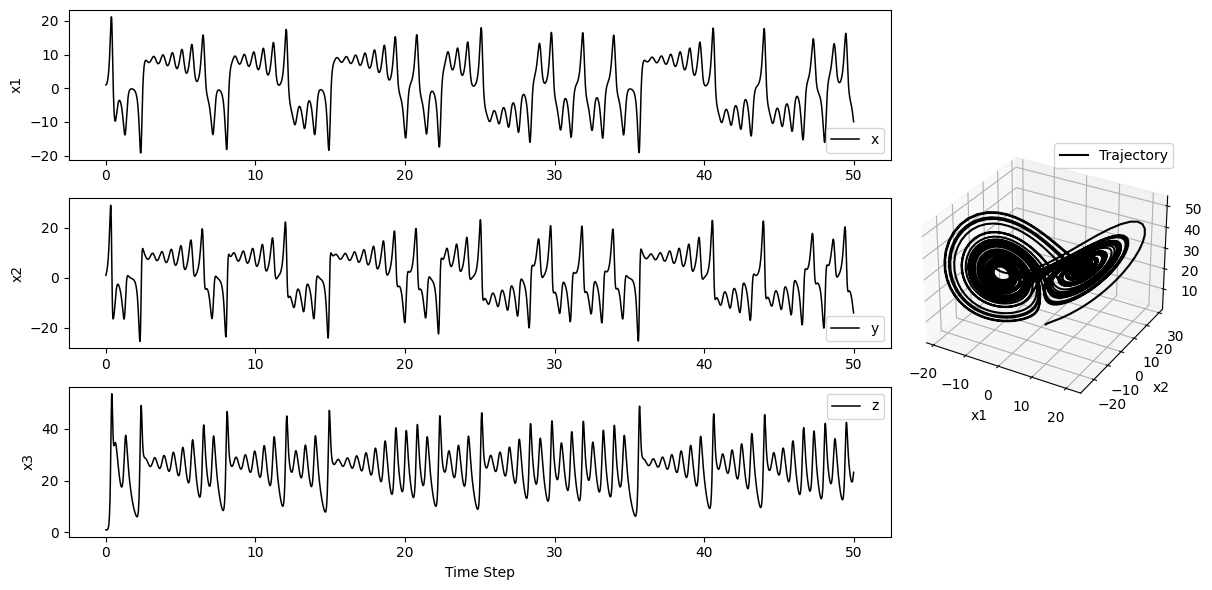

In [78]:

def plotLorenz(t, x1, x2, x3):
  # Create a GridSpec to allocate space for the subplots
  fig = plt.figure(figsize=(12, 6))
  gs = fig.add_gridspec(3, 2, width_ratios=[3, 1])

  # Create the first three subplots
  ax0 = fig.add_subplot(gs[0, 0])
  ax0.plot(t, x1, label="x", color="k", lw=1.1)
  ax0.set_ylabel("x1")
  ax0.legend()

  ax1 = fig.add_subplot(gs[1, 0])
  ax1.plot(t, x2, label="y", color="k", lw=1.1)
  ax1.set_ylabel("x2")
  ax1.legend()

  ax2 = fig.add_subplot(gs[2, 0])
  ax2.plot(t, x3, label="z", color="k", lw=1.1)
  ax2.set_ylabel("x3")
  ax2.legend()
  ax2.set_xlabel("Time Step")

  # Create the 3D subplot
  ax3 = fig.add_subplot(gs[:, 1], projection='3d')
  ax3.plot(x1, x2, x3, label="Trajectory", color="k")
  ax3.set_xlabel("x1")
  ax3.set_ylabel("x2")
  ax3.set_zlabel("x3")
  ax3.legend()

  # Adjust layout
  fig.tight_layout()
  plt.show()

plotLorenz(t,x1,x2,x3)

In [79]:
def plot_xyz(t_val, xyz_val, xyz_pred):

  x_val = xyz_val[:,0]
  y_val = xyz_val[:,1]
  z_val = xyz_val[:,2]
  x_pred = xyz_pred[:,0]
  y_pred = xyz_pred[:,1]
  z_pred = xyz_pred[:,2]

  fig, axs = plt.subplots(3, 1, figsize=(8, 6))

  axs[0].plot(t_val, x_val, label="x Lorenz", color="k", lw=1.1)
  axs[0].plot(t_val, x_pred, label="x prediction", color="orange", lw=0.9)
  axs[0].set_ylabel("x")
  axs[0].legend()

  axs[1].plot(t_val, y_val, label="y Lorenz", color="k", lw=1.1)
  axs[1].plot(t_val, y_pred, label="y prediction", color="orange", lw=0.9)
  axs[1].set_ylabel("y")
  axs[1].legend()

  axs[2].plot(t_val, z_val, label="z Lorenz", color="k", lw=1.1)
  axs[2].plot(t_val, z_pred, label="z prediction", color="orange", lw=0.9)
  axs[2].set_ylabel("z")
  axs[2].legend()

  axs[2].set_xlabel("Time Step")

  fig.tight_layout()
  plt.show()


def plot_y(t_val, y_val, y_pred):
  # Plot y_pred and y_val
  fig, ax = plt.subplots(figsize=(8, 4))

  ax.plot(t_val, y_val, label="y Lorenz", color="k", lw=1.1)
  ax.plot(t_val, y_pred, label="y prediction", color="orange", lw=0.9)
  ax.set_ylabel("y")
  ax.set_xlabel("Time Step")
  ax.legend()

  fig.tight_layout()
  plt.show()


In [110]:
class Reservoir:
  def __init__(self, train_data, dim_reservoir = 500, edge_probability = 0.1, max_singular_value = 1):
    self.dim_system = train_data.shape[1] if len(train_data.shape) > 1 else 1
    self.dim_reservoir = dim_reservoir
    self.edge_probability = edge_probability
    self.train_data = train_data
    #self.W_in = 2 * edge_probability * (np.random.rand(dim_reservoir, self.dim_system) - .5) # This works
    #self.W_in = np.random.normal(0, 0.02, size=(self.dim_reservoir, self.dim_system))
    self.reservoir_state = np.zeros(dim_reservoir)


    # Christians initialization
    self.W_in = np.random.normal(0, 0.02, size=(self.dim_reservoir, self.dim_system))

    self.W_out = np.random.uniform(-0.1, 0.1, size=(self.dim_reservoir, self.dim_system))

    #scaling_factor = 1.1
    graph = nx.gnp_random_graph(dim_reservoir, edge_probability)
    graph = nx.to_numpy_array(graph)
    A = 2 * (np.random.rand(dim_reservoir, dim_reservoir) - 0.5) * graph # This works
    #A = np.random.normal(0, 0.05, size=(self.dim_reservoir, self.dim_reservoir)) * graph # Christians way
    U, Sigma, VT = np.linalg.svd(A, full_matrices=False)
    Sigma = np.clip(Sigma, None, max_singular_value)  # Cap the singular values to not exceed max_singular_value

    # Reconstruct A
    self. A = np.dot(U, np.dot(np.diag(Sigma), VT))
    self.W_out = np.zeros((self.dim_system, dim_reservoir))

    #if activation_function == 'tanh':
      #self.activation_function = np.tanh
    #elif activation_function == 'sigmoid':
      #self.activation_function = self.sigmoid

  #def sigmoid(self, x): # Maybe use tanh
    #return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

  def train(self, regularization_factor = 0.0001):
    R = np.zeros((self.dim_reservoir, self.train_data.shape[0]))
    self.reservoir_state = np.zeros(self.dim_reservoir)

    for i in range(self.train_data.shape[0]):
        R[:, i] = self.reservoir_state
        self.reservoir_state = np.tanh(np.dot(self.A, self.reservoir_state) + np.dot(self.W_in, self.train_data[i]))

    Rt = np.transpose(R)
    inverse_part = np.linalg.inv(np.dot(R, Rt)
                             + regularization_factor * np.identity(R.shape[0]))  # Inverse
    self.W_out = np.dot(np.dot(self.train_data.T, Rt), inverse_part)

  def predict(self, validation_data):
    step_to_be_predicted = len(validation_data)
    prediction = np.zeros((step_to_be_predicted, self.dim_system))

    for i in range(step_to_be_predicted):
      prediction[i] = np.dot(self.W_out, self.reservoir_state)
      self.reservoir_state = np.tanh(np.dot(self.A, self.reservoir_state)
                              + np.dot(self.W_in, prediction[i]))

    return prediction







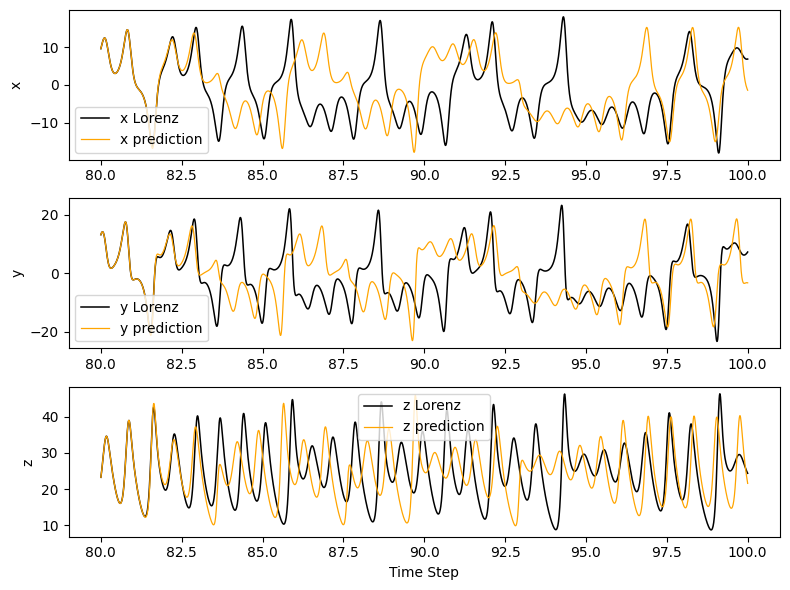

In [81]:
# Assume lorenz function returns lists or arrays for x1, x2, x3
t, x1, x2, x3 = lorenz(t0=0, x0=1, y0=1, z0=1, dt=0.01,
                       sigma=10, rho=28, beta=8/3, iter_num=10_000)

data = np.array([x1, x2, x3])

iter_num = 10_000
split_idx = int(np.round(0.8 * iter_num))
data = data.T
train_data = data[:split_idx, :]
val_data = data[split_idx:, :]


t = np.array(t)
t_train = t[:split_idx]
t_val = t[split_idx:]

# Initialize the Reservoir, train it, predict
reservoir = Reservoir(train_data, max_singular_value=1)
reservoir.train()
pred = reservoir.predict(val_data)
plot_xyz(t_val, val_data, pred)

10


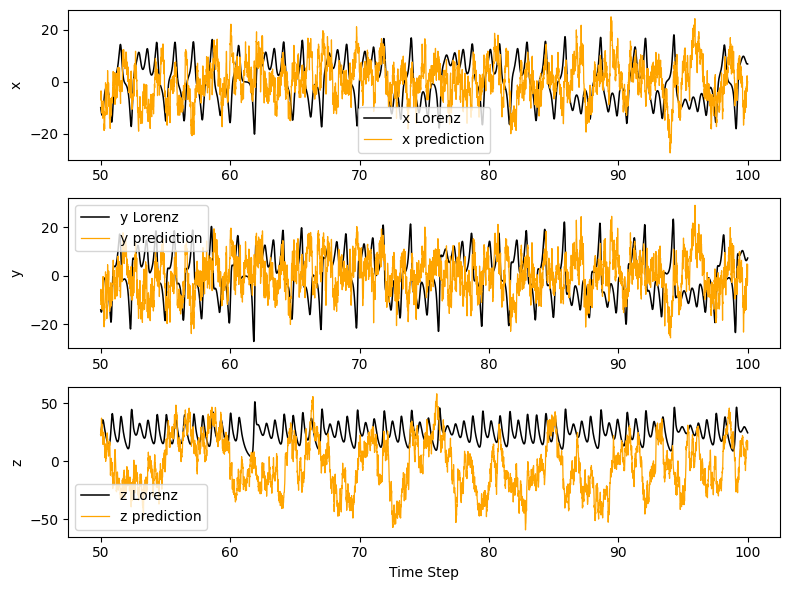

In [109]:
reservoir = Reservoir(train_data, max_singular_value=10)
reservoir.train()
pred = reservoir.predict(val_data)
plot_xyz(t_val, val_data, pred)

(2001, 1)
(2001, 1)
(2001,)
[[13.20888063]
 [13.52978906]
 [13.79963097]
 ...
 [-8.86445421]
 [-9.26448472]
 [-9.67579996]]
[[13.20885414]
 [13.53004382]
 [13.80071802]
 ...
 [ 6.96508744]
 [ 7.11628895]
 [ 7.27920934]]


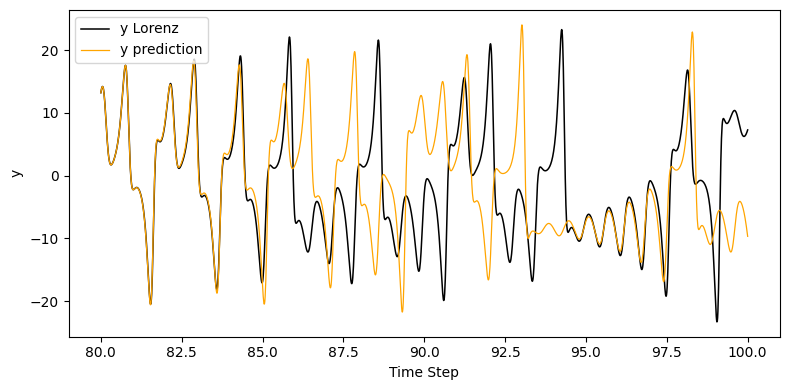

In [83]:
t, x1, x2, x3 = lorenz(t0=0, x0=1, y0=1, z0=1, dt=0.01,
                       sigma=10, rho=28, beta=8/3, iter_num=10_000)

iter_num = 10_000
split_idx = int(np.round(0.8 * iter_num))

train_x2 = x2[:split_idx]
val_x2 = x2[split_idx:]

# Reshape data to meet the input requirement of Reservoir
train_x2 = train_x2.reshape(-1, 1)
val_x2 = val_x2.reshape(-1, 1)

# Initialize and train the reservoir
reservoirx = Reservoir(train_x2, max_singular_value=1)
reservoirx.train()
y_pred = reservoirx.predict(val_x2)

print(y_pred.shape)
print(val_x2.shape)
print(t_val.shape)
print(y_pred)
print(val_x2)

plot_y(t_val, val_x2, y_pred)

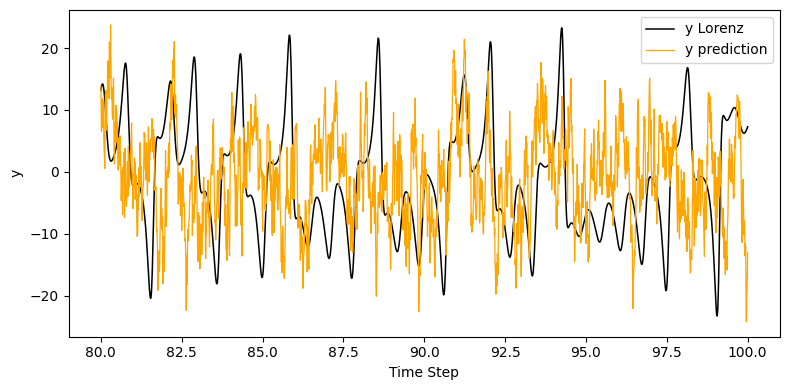

In [84]:
t, x1, x2, x3 = lorenz(t0=0, x0=1, y0=1, z0=1, dt=0.01,
                       sigma=10, rho=28, beta=8/3, iter_num=10_000)

iter_num = 10_000
split_idx = int(np.round(0.8 * iter_num))

train_x2 = x2[:split_idx]
val_x2 = x2[split_idx:]

# Reshape data to meet the input requirement of Reservoir
train_x2 = train_x2.reshape(-1, 1)
val_x2 = val_x2.reshape(-1, 1)

#plt.plot(val_x2)
# Initialize and train the reservoir
reservoirx = Reservoir(train_x2, max_singular_value=10)
reservoirx.train()
y_pred = reservoirx.predict(val_x2)

#plt.plot(val_x2)

plot_y(t_val, val_x2, y_pred)

In [85]:
def forecast_horizon(validation_data, predicted, threshold=5, dt=0.01):
    # Calculate element-wise squared differences
    squared_diff = np.square(validation_data - predicted)

    # Check the number of dimensions and sum accordingly
    if validation_data.ndim == 2 and validation_data.shape[1] == 1:
        squared_sum = squared_diff.flatten()  # Treat it as 1D
    elif validation_data.ndim == 2 and validation_data.shape[1] == 3:
        squared_sum = np.sum(squared_diff, axis=1)  # Sum across the feature axis for 3 features
    else:
        raise ValueError("Unsupported shape. Expected (n_samples, 1) or (n_samples, 3).")

    # Take the square root to get the Euclidean distance for each sample/time point
    euclidean_distance = np.sqrt(squared_sum)

    # Find the indices where the Euclidean distance exceeds the threshold
    exceed_indices = np.where(euclidean_distance > threshold)[0]

    if len(exceed_indices) == 0:
        # Return the full duration if no sample exceeds the threshold
        return len(validation_data) * dt
    else:
        # Return the time of the first sample that exceeds the threshold
        return exceed_indices[0] * dt


x2_real = np.array([1,2,3,1]).reshape(-1, 1)
x2_pred = np.array([2,4,6,100]).reshape(-1, 1)
#test, dist = forecast_horizon(x2_real, x2_pred)
#print(test)
#print(dist)


# Define real data
x2_real_3d = np.array([
    [0, 0, 0],  # Origin for reference
    [1, 0, 0],  # Distance of about 1 from the next point
    [2, 1, 1],  # Distance of about 2 from the next point
    [3, 1, 1]   # Distance of about 3 from the next point (more for dramatic effect)
])

# Define predicted data such that the distances are as described
x2_pred_3d = np.array([
    [1, 0, 0],        # Distance of about 1 from the first real point
    [1, 2, 1],        # Distance of about 2 from the second real point
    [2, 4, 4],        # Distance of about 3 from the third real point
    [103, 1, 1]       # Large distance from the fourth real point
])

# Now you can call the function with the 3D data
#test, dist = forecast_horizon(x2_real_3d, x2_pred_3d, threshold=5)
#print(test)
#print(dist)



#print(val_data)
#print(pred)
#test, dist = forecast_horizon(val_data, pred)
#print(dist)
#print(test)
#print(test*0.01)
#print(val_data.shape)
#print(forecast_horizon(val_x2, y_pred))

In [103]:
t, x1, x2, x3 = lorenz(t0=0, x0=1, y0=1, z0=1, dt=0.01,
                       sigma=10, rho=28, beta=8/3, iter_num=10_000)

data = np.array([x1, x2, x3])
iter_num = 10_000
split_idx = int(np.round(0.5 * iter_num))
max_singular_values = np.linspace(0.01,10,15) # CHANGE TO MORE VALUES

# Split full data
data = np.array([x1, x2, x3])
data = data.T
train_data = data[:split_idx, :]
val_data = data[split_idx:, :]

# Split x2_data
train_x2 = x2[:split_idx]
val_x2 = x2[split_idx:]

train_x2 = train_x2.reshape(-1, 1)
val_x2 = val_x2.reshape(-1, 1)

# Splitting t
t = np.array(t)
t_train = t[:split_idx]
t_val = t[split_idx:]

# Save the forcast_horizon scores
full_score = []
x2_score = []

threshold = 5


# Initialize accumulators as numpy arrays for element-wise operations
full_score = np.zeros(len(max_singular_values))
x2_score = np.zeros(len(max_singular_values))

iter = 20
for i in range(iter):
    tmp_full_score = []
    tmp_x2_score = []

    print(i)

    for j, singular_value in enumerate(max_singular_values):
        # Full model
        reservoir = Reservoir(train_data, max_singular_value=singular_value)
        reservoir.train()
        y_pred = reservoir.predict(val_data)

        # x2 model
        reservoirx = Reservoir(train_x2, max_singular_value=singular_value)
        reservoirx.train()
        y_pred_x2 = reservoirx.predict(val_x2)

        # Calculate forecast horizons
        full_forecast = forecast_horizon(val_data, y_pred, threshold, dt=0.01)
        x2_forecast = forecast_horizon(val_x2, y_pred_x2, threshold, dt=0.01)

        # Accumulate results
        tmp_full_score.append(full_forecast)
        tmp_x2_score.append(x2_forecast)

    # Element-wise addition of the results from this iteration
    full_score += np.array(tmp_full_score)
    x2_score += np.array(tmp_x2_score)

# Average the scores over all iterations
full_score /= iter
x2_score /= iter

print("Average Full Score:", full_score)
print("Average X2 Score:", x2_score)





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Average Full Score: [3.4005e+00 3.4260e+00 2.4770e+00 1.0850e-01 2.9500e-02 1.3000e-02
 6.0000e-03 8.5000e-03 5.5000e-03 5.0000e-03 2.0000e-03 6.5000e-03
 5.0000e-03 5.5000e-03 4.0000e-03]
Average X2 Score: [0.593  1.103  0.4125 0.176  0.0815 0.0495 0.025  0.02   0.027  0.0305
 0.0095 0.0105 0.016  0.0145 0.014 ]


[3.4005e+00 3.4260e+00 2.4770e+00 1.0850e-01 2.9500e-02 1.3000e-02
 6.0000e-03 8.5000e-03 5.5000e-03 5.0000e-03 2.0000e-03 6.5000e-03
 5.0000e-03 5.5000e-03 4.0000e-03]
[0.593  1.103  0.4125 0.176  0.0815 0.0495 0.025  0.02   0.027  0.0305
 0.0095 0.0105 0.016  0.0145 0.014 ]


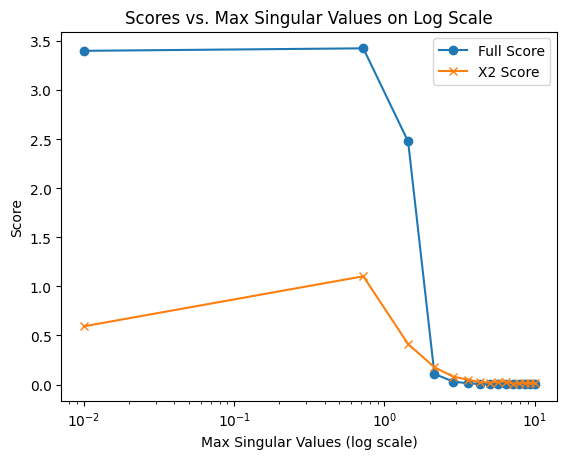

In [104]:
print(full_score)
print(x2_score)

# Assuming max_singular_values, full_score, and x2_score are defined
plt.plot(max_singular_values, full_score, label='Full Score', marker='o')
plt.plot(max_singular_values, x2_score, label='X2 Score', marker='x')

plt.xlabel('Max Singular Values')
plt.ylabel('Score')
plt.title('Scores vs. Max Singular Values')
plt.legend()


plt.show()

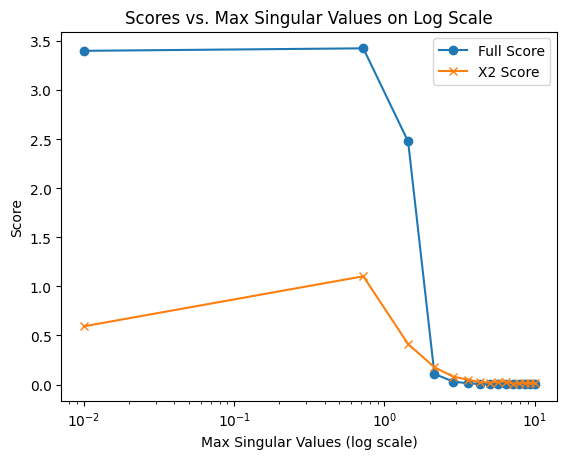

In [105]:
# Assuming max_singular_values, full_score, and x2_score are defined
plt.semilogx(max_singular_values, full_score, label='Full Score', marker='o', linestyle='-', markersize=6)
plt.semilogx(max_singular_values, x2_score, label='X2 Score', marker='x', linestyle='-', markersize=6)

plt.xlabel('Max Singular Values (log scale)')
plt.ylabel('Score')
plt.title('Scores vs. Max Singular Values on Log Scale')
plt.legend()

plt.show()